In [6]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


#### Common funcs

In [1]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = np.concatenate(np.array(list(map(np.array, states_batch)))[np.array(rewards_batch) >= reward_threshold])
    elite_actions = np.concatenate(np.array(list(map(np.array, actions_batch)))[np.array(rewards_batch) >= reward_threshold])

    return elite_states, elite_actions

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

#### Tabular funcs

In [4]:
def tabular_generate_session(env, policy, t_max=10000):

    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(np.arange(6), p=policy[s])
        new_s, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

def update_policy(elite_states, elite_actions, shape):
    n_states, n_actions = shape
    new_policy = np.zeros([n_states, n_actions])
    
    for i in range(len(elite_states)):
        new_policy[elite_states[i], elite_actions[i]] += 1
    
    for i in range(n_states):
        curr_state_sum = sum(new_policy[i])  
        if  curr_state_sum > 0:
            new_policy[i] = new_policy[i] / curr_state_sum
        else:
            new_policy[i] = np.ones(6) / 6 
            
    return new_policy

def tabular_experiment(env, n_sessions, percentile, learning_rate, n_iter=100, visualize=True):
    env.reset()
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    policy = np.ones([n_states, n_actions]) / n_actions
    log = []

    for i in range(n_iter):
        sessions = [tabular_generate_session(env, policy) for i in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
        new_policy = update_policy(elite_states, elite_actions, (n_states, n_actions))
        #fit
        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        if visualize:
            show_progress(rewards_batch, log, percentile)
        
    return np.mean(rewards_batch)

In [38]:
grid_params = {'n_sessions':[50, 100, 250, 500, 750],
               'percentile': [5, 20, 40, 60, 80, 95],
               'learning_rate': [0.3, 0.5, 0.7]}

keys = list(grid_params.keys())
comb_params = [{keys[0]: x} for x in grid_params[keys[0]]]
for i in range(1, len(keys)):
    comb_params = [{**x, **{keys[i]: y}} for x in comb_params for y in grid_params[keys[i]]]

results = dict()
for i, params in enumerate(comb_params):
    curr_result = taxi_experiment(env = gym.make("Taxi-v3"), n_iter=150, visualize=False, **params)
    results[tuple(params.values())] = curr_result
    print('Iterations: {0} from {1}, params: {2}, result: {3}'.format(i+1, len(comb_params), params, curr_result))

Iterations: 1 from 90, params: {'n_sessions': 50, 'percentile': 5, 'learning_rate': 0.3}, result: -390.38
Iterations: 2 from 90, params: {'n_sessions': 50, 'percentile': 5, 'learning_rate': 0.5}, result: -560.94
Iterations: 3 from 90, params: {'n_sessions': 50, 'percentile': 5, 'learning_rate': 0.7}, result: -454.88
Iterations: 4 from 90, params: {'n_sessions': 50, 'percentile': 20, 'learning_rate': 0.3}, result: -195.24
Iterations: 5 from 90, params: {'n_sessions': 50, 'percentile': 20, 'learning_rate': 0.5}, result: -146.54
Iterations: 6 from 90, params: {'n_sessions': 50, 'percentile': 20, 'learning_rate': 0.7}, result: -362.9
Iterations: 7 from 90, params: {'n_sessions': 50, 'percentile': 40, 'learning_rate': 0.3}, result: -87.98
Iterations: 8 from 90, params: {'n_sessions': 50, 'percentile': 40, 'learning_rate': 0.5}, result: -178.38
Iterations: 9 from 90, params: {'n_sessions': 50, 'percentile': 40, 'learning_rate': 0.7}, result: -199.48
Iterations: 10 from 90, params: {'n_sessio

KeyboardInterrupt: 

mean reward = -66.258, threshold=-200.000


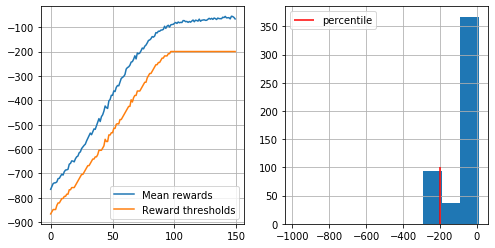

Wall time: 6min 3s


In [7]:
%%time
result = tabular_experiment(env = gym.make("Taxi-v3"), 
                         n_sessions=500, 
                         percentile=10,
                         learning_rate=0.5, 
                         n_iter=150, 
                         visualize=True)

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pt) Devise a way to speed up training against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
__Please list what you did in anytask submission form__. __It's necessary to measure your improvement experimentally__.  __You score depends on this improvement. If the algorithm converges 2x faster, you obtain 3 pts. If the algorithm converges 4x faster, you obtain 6pts__.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

C:\Users\A_Pot\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


state vector dim = 2
n_actions = 3


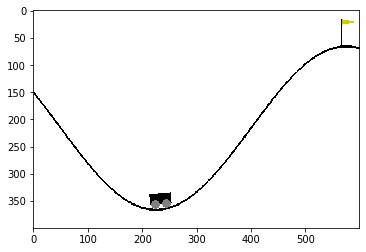

In [2]:
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [54]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [5]:
s = env.reset()

In [7]:
s

array([-0.5051632,  0.       ])

In [55]:
probs = agent.predict_proba([s])[0]

In [58]:
probs

array([0.31882129, 0.2844915 , 0.39668721])

In [65]:
generate_session(env, agent, t_max=10000)[2]

-10000.0

In [30]:
def generate_session(env, agent, t_max=10000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]
        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        a = np.random.choice(np.arange(n_actions), p=probs)
        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = np.concatenate(np.array(list(map(np.array, states_batch)))[np.array(rewards_batch) >= reward_threshold])
    elite_actions = np.concatenate(np.array(list(map(np.array, actions_batch)))[np.array(rewards_batch) >= reward_threshold])

    return elite_states, elite_actions

def show_progress(rewards_batch, log, percentile, reward_range=[-10000, +100]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [24]:
sessions = [generate_session(env, agent) for i in range(n_sessions)]

mean reward = -132.030, threshold=-113.000


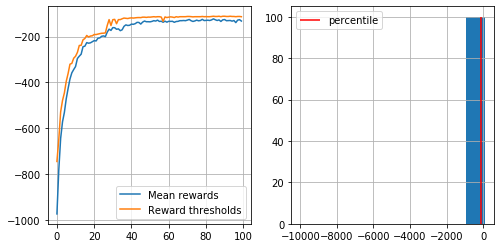

In [32]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions =select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.fit(elite_states, elite_actions)
    
    show_progress(rewards_batch, log, percentile)

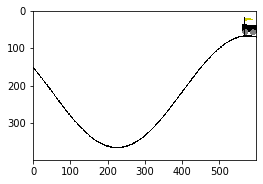

In [34]:
from IPython import display

# create env manually to set time limit. Please don't change this.
TIME_LIMIT = 10000
s = env.reset()
actions = {'left': 0, 'stop': 1, 'right': 2}

plt.figure(figsize=(4, 3))
display.clear_output(wait=True)

for t in range(TIME_LIMIT):
    plt.gca().clear()
    
    # change the line below to reach the flag
    probs = agent.predict_proba([s])[0]
    a = np.random.choice(np.arange(n_actions), p=probs)
    s, r, done, info = env.step(a)
        
    # draw game image on display
    plt.imshow(env.render('rgb_array'))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

display.clear_output(wait=True)

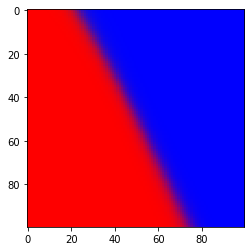

In [33]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

plt.imshow(visualize_mountain_car(env, agent))

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).